In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

TINY_SIZE = 14
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
sns.set(style="darkgrid")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": BIGGER_SIZE,
    "axes.labelsize": BIGGER_SIZE,
    "axes.titlesize": BIGGER_SIZE,
    "xtick.labelsize": TINY_SIZE, 
    "ytick.labelsize": TINY_SIZE, 
    "legend.fontsize": MEDIUM_SIZE, 
    "figure.titlesize": BIGGER_SIZE, 
})

In [15]:
def load_data(paths: list, num_runs: int=1000):
    aggregated_df = pd.DataFrame()
    length = 0
    for idx, path in enumerate(paths):
        # Read run data
        df = pd.read_csv(path)
        length += len(df.index)

        df["run"] += idx * num_runs

        df["action"] = df["action"].map(lambda x: 10**x)

        aggregated_df = pd.concat([aggregated_df, df], ignore_index=True)
    assert length == len(aggregated_df.index)
    return aggregated_df

def fill_missing_values(group, metric):
    last_value = group[metric].iloc[-1]

    # Create full run
    all_steps = pd.DataFrame({"batch": range(101)})

    # Merge group with full run
    filled_group = pd.merge(all_steps, group, on="batch", how="left")

    filled_group["run"] = group["run"].iloc[0]
    filled_group[metric] = filled_group[metric].fillna(last_value)

    return filled_group

In [16]:
data_const_0 = pd.read_csv("../data_intro/ToySGD/constant/42/Ackley/aggregated_run_data.csv")
#data_const_1 = pd.read_csv("../data_intro/ToySGD/constant/42/Rastrigin/aggregated_run_data.csv")
data_const_1 = pd.read_csv("../data_intro/ToySGD/constant/43/Ackley/aggregated_run_data.csv")
data_const_2 = pd.read_csv("../data_intro/ToySGD/constant/44/Ackley/aggregated_run_data.csv")
data_sgdr_0 = pd.read_csv("../data_intro/ToySGD/sgdr/0/Ackley/aggregated_run_data.csv")

dir_path = "../data_homo_256_60k_Ackley_const"
run_data_path = []
for path in (Path(dir_path) / "results" / "td3_bc").rglob(
            "*/eval_data.csv",
        ):
    run_data_path.append(path)

data_agent = load_data(run_data_path)

data_all = [data_const_0, data_const_1, data_const_2, data_sgdr_0, data_agent]
labels = ["$\\alpha = 0.001$", "$\\alpha = 0.005$", "$\\alpha = 0.01$", "SGDR", "Learned Schedule"]

for i, data in enumerate(data_all):
    print(i)
    data_required_df = data[["f_cur", "run", "batch"]]
    data_filled = (
        data_required_df.groupby("run")
        .apply(fill_missing_values, "f_cur")
        .reset_index(drop=True)
    )
    data_all[i] = data_filled

0
1
2
3
4


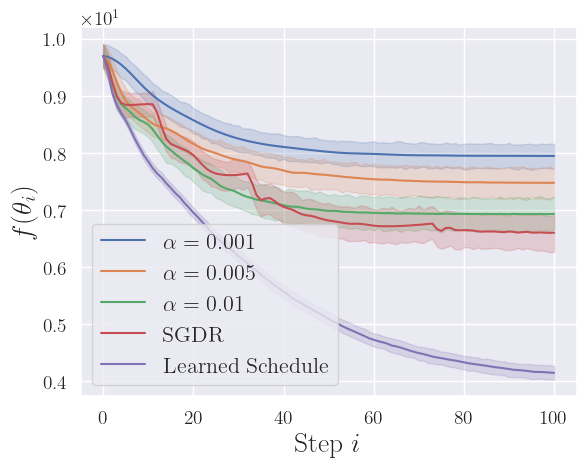

In [17]:
for data, label in zip(data_all, labels):
    ax = sns.lineplot(data,
                      x="batch",
                      y="f_cur",
                      label=label,
                      errorbar=("ci", 99))

plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
#ax.set_yscale("log")
ax.set_xlabel("Step $i$")
ax.set_ylabel("$f(\\theta_i)$")
plt.savefig(Path("figures", "intro.pdf"), bbox_inches="tight")